## AI Hack Tunisia #3 - NLP challenge
### Multi-Turn Response Selection Task with Tunisian dialect
### [The challenge on Zindi.Africa](https://zindi.africa/competitions/ai-hack-tunisia-3-nlp-challenge)
### Badri Ahmed

#### Importing Librairies

In [1]:
#Import Librairies
import pickle
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter 
from langdetect import detect
from stop_words import get_stop_words
import nltk
from nltk import RegexpTokenizer
import re
import multiprocessing
from gensim.models import Word2Vec
from time import time
#Disable warnings
import warnings
warnings.filterwarnings("ignore") 

#### Let's extract the data and have a quick look

In [2]:
with open('train.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data.tail(10)

,Id,c,r,y
84990,84990,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,Composez *177*2# pour désactiver renouvellemen...,1
84991,84991,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,mtei Télécom noumrouya mahbech ibthli coed ko...,0
84992,84992,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,Mahlakoum,0
84993,84993,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,bech nbdel puce o5rra Ooredoo yesser mstouha ...,0
84994,84994,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,فيشطة ليوم وإلا تخدمو,0
84995,84995,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,دينار,0
84996,84996,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,Bonjour famechi facilité,0
84997,84997,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,الكنكسيون طايح جملا,0
84998,84998,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,الوقتاش العرض باقي شكرا,0
84999,84999,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,Avec service Tasshil vous pouvez acheter port...,0


#### You can notice that the conversation in the "c" column is repeated 10 times, with 10 different answers in column "r". The correct answer corresponds to the value '1' in the "y" column

#### First thing, we will transform all our text to lower to avoid repeated entities

In [4]:
data.c = data.c.apply(str.lower)
data.r = data.r.apply(str.lower)

#### To reduce processing time, we will remove duplicate discussions, to consult our data.

In [5]:
Data = data[['Id','c']]

In [6]:
Data.drop_duplicates(subset ="c", keep = 'first', inplace = True) 

In [7]:
Data.head()

,Id,c
0,0,_t_ comment faire pour choisir bonne musique ...
10,10,_t_ الانترنات غرامك عليك بالـ forfait flexi ت...
20,20,_t_ عندي سؤال: وقتلي شريت اوريدو صححة يتجدد ت...
30,30,_t_ yezi te5ssro barcha wzid esr9o mnha _t_ b...
40,40,_t_ شبيه ريزو الانترنيت ضعيف وزيد الفورفي تتكل


#### Every cell contains a conversation. Comments are seperated using '_t_'. Now we will seperate comments

In [8]:
Comments = pd.DataFrame()

In [9]:
ind = 0
for index,row in Data.iterrows():  
    text = str(row['c'])
    Discussion = text.split(' _t_ ')
    for Text in Discussion :
        if Text != '':
            Comments.at[ind,'Id']=row['Id']
            Comments.at[ind,'Text']=Text
            ind+=1

In [10]:
Comments.head()

,Id,Text
0,0.0,comment faire pour choisir bonne musique pour ...
1,0.0,bonsoir rimo simple consultez catalogue toutes...
2,0.0,merci peux donner musique numero
3,0.0,vous cherchez titre bien déterminé lotfi commu...
4,0.0,connais jara


#### Now we will use 'Wordcloud to have a quick look at the most used terms

In [11]:
Words = ''
for index,row in Comments.iterrows():
    Words=Words+" "+row["Text"]

In [12]:
#Settings
wordcloud_pos=WordCloud(max_font_size=100, max_words=150, background_color="white").generate(Words)

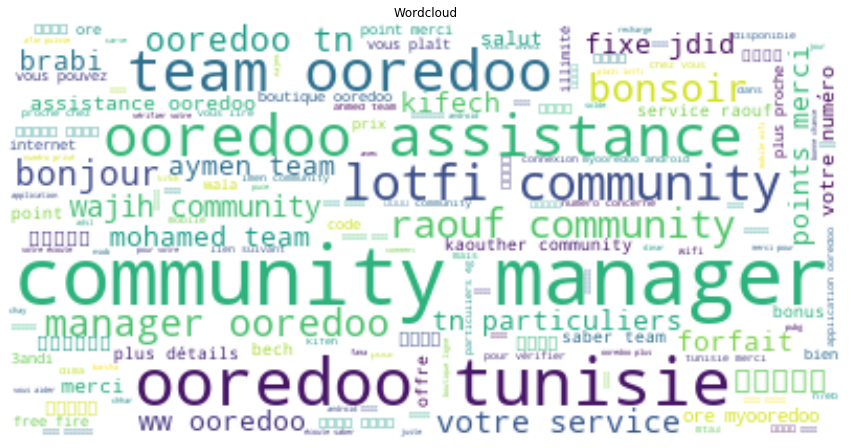

In [13]:
#Plotting the words
plt.figure(figsize=(15,15))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud")
plt.show()

#### We can see that some words are meaningless or have a special context, we will be using them later
#### You can also see that arabic words are being displayed with squares

#### Another way to see the most used words, is using Word counter.

In [14]:
Splt = Words.split(' ')
Counter = Counter(Splt)
most_occur = Counter.most_common(20)  
print(most_occur)

[('ooredoo', 1935), ('community', 1170), ('manager', 1162), ('vous', 1063), ('votre', 880), ('tunisie', 753), ('pour', 585), ('merci', 564), ('team', 531), ('assistance', 531), ('lotfi', 385), ('raouf', 377), ('service', 368), ('مرحبا', 332), ('bonsoir', 317), ('forfait', 286), ('plus', 284), ('bonjour', 281), ('mohamed', 264), ('points', 252)]


#### We will store the 20 most used terms so we can use them later in the cleaning

In [15]:
MstUsed = ['_t_']
for tup in most_occur:
    MstUsed.append(tup[0])

#### Since our data is written in French, Tunisian is using Latin characters, and Tunisian is using Arabic characters. We will use a module called 'langdetect' to seperate the data with the comment language. It is not so accurate but it will help us acheive good results

In [16]:
for index,row in Comments.iterrows():
    try:
        Lang = detect(row['Text'])
    except:
        Lang = 'NN'
    Comments.at[index,'Lang'] = Lang

In [17]:
Comments.Lang.unique()

array(['fr', 'ar', 'en', 'so', 'ro', 'af', 'pt', 'fa', 'pl', 'da', 'sv',
       'tr', 'fi', 'id', 'nl', 'sw', 'et', 'cs', 'vi', 'tl', 'cy', 'hr',
       'no', 'hu', 'de', 'sq', 'sk', 'lv', 'es', 'it', 'ca', 'NN', 'sl',
       'ur', 'lt'], dtype=object)

#### As you can see, more than 30 language are detected, but the Tunisian dialect is the one causing confusion to the detector. After investigating, we can sort the comments like this : 
1. 'fr' and 'en' for French and English
2. 'ar' and 'fa' for Comments written with Arabic characters
3. The rest for the Tunisian written with latin words

In [18]:
French = Comments[np.logical_or(Comments.Lang=='fr' , Comments.Lang=='en')]
Arabic = Comments[np.logical_or( Comments.Lang=='ar' , Comments.Lang=='fa' )]
Tunisian = Comments[np.logical_not(np.logical_or(np.logical_or(Comments.Lang=='fr' , Comments.Lang=='en'),np.logical_or( Comments.Lang=='ar' , Comments.Lang=='fa' )))]

In [19]:
French.head()

,Id,Text,Lang
0,0.0,comment faire pour choisir bonne musique pour ...,fr
1,0.0,bonsoir rimo simple consultez catalogue toutes...,fr
2,0.0,merci peux donner musique numero,fr
3,0.0,vous cherchez titre bien déterminé lotfi commu...,fr
4,0.0,connais jara,fr


In [20]:
Arabic.head()

,Id,Text,Lang
8,10.0,الانترنات غرامك عليك بالـ forfait flexi تمتع ا...,ar
10,10.0,تنجم تستعملها تيوب,ar
16,20.0,عندي سؤال: وقتلي شريت اوريدو صححة يتجدد تلقائي...,ar
19,40.0,شبيه ريزو الانترنيت ضعيف وزيد الفورفي تتكل,ar
21,50.0,عسلامة يمكنك إستعمال خدمة ta7wil للتحويل رصيد ...,ar


In [21]:
Tunisian.head()

,Id,Text,Lang
11,10.0,مرحبا توضحلي أكثر الطلب متاعك faten team oored...,so
12,10.0,tidjeni rachid ouii testa3melha chayy,ro
13,10.0,ooredoo tunisie na7ki forfait hadha mta3,af
15,10.0,ooredoo tunisie ligne business,af
17,30.0,yezi te5ssro barcha wzid esr9o mnha,pt


#### So far so good. Now, we will see most used words in each dataset

In [22]:
#French
WordsFr = ''
for index,row in French.iterrows():
    WordsFr=WordsFr+" "+row["Text"]

In [23]:
from collections import Counter 
SpltFr = WordsFr.split(' ')
CounterFr = Counter(SpltFr)
most_occur = CounterFr.most_common(50)  
print(most_occur)

[('vous', 1051), ('community', 897), ('manager', 887), ('votre', 868), ('ooredoo', 666), ('pour', 580), ('service', 334), ('bonsoir', 311), ('merci', 308), ('raouf', 298), ('lotfi', 297), ('plus', 276), ('assistance', 276), ('team', 274), ('bonjour', 271), ('numéro', 220), ('avec', 204), ('points', 192), ('wajih', 192), ('forfait', 183), ('offre', 182), ('nous', 157), ('mois', 156), ('tunisie', 148), ('privé', 148), ('internet', 128), ('fixe', 122), ('détails', 118), ('pouvez', 117), ('salut', 117), ('mohamed', 117), ('boutique', 116), ('vérifier', 115), ('dans', 110), ('facture', 110), ('afin', 106), ('ligne', 106), ('jdid', 103), ('application', 98), ('veuillez', 93), ('connexion', 88), ('faire', 85), ('lien', 84), ('bien', 83), ('pack', 80), ('mobile', 78), ('avoir', 78), ('aymen', 77), ('ahmed', 75), ('communiquer', 75)]


In [24]:
#Arabic
WordsAr = ''
for index,row in Arabic.iterrows():
    WordsAr=WordsAr+" "+row["Text"]

In [25]:
from collections import Counter 
SpltAr = WordsAr.split(' ')
CounterAr = Counter(SpltAr)
most_occur = CounterAr.most_common(50)  
print(most_occur)

[('ooredoo', 489), ('مرحبا', 255), ('community', 229), ('manager', 229), ('team', 210), ('assistance', 210), ('كيفاش', 202), ('دينار', 184), ('بربي', 171), ('تنجم', 165), ('عندي', 151), ('اوريدو', 128), ('أكثر', 120), ('أدخل', 120), ('متاع', 114), ('رقمك', 111), ('شكرا', 106), ('tunisie', 106), ('ذمتك', 104), ('نعمل', 101), ('متاعك', 100), ('الله', 95), ('السلام', 94), ('mohamed', 91), ('علاش', 90), ('http://ore.do/myooredoo', 86), ('رسالة', 82), ('لمدة', 81), ('android', 78), ('خاصة', 77), ('احنا', 76), ('تاليفونك', 76), ('نشري', 76), ('aymen', 72), ('ديما', 71), ('بالله', 71), ('العرض', 71), ('الرابط', 70), ('عليك', 68), ('قداش', 68), ('lotfi', 67), ('مرسي', 66), ('تعطينا', 66), ('عندك', 62), ('raouf', 62), ('الخير', 60), ('تونس', 60), ('نقاط', 60), ('نقطة', 60), ('نعرف', 59)]


In [26]:
#Tunisian
WordsTn = ''
for index,row in Tunisian.iterrows():
    WordsTn=WordsTn+" "+row["Text"]

In [27]:
from collections import Counter 
SpltTn = WordsTn.split(' ')
CounterTn = Counter(SpltTn)
most_occur = CounterTn.most_common(50)  
print(most_occur)

[('ooredoo', 780), ('tunisie', 499), ('merci', 197), ('kifech', 125), ('brabi', 111), ('bech', 67), ('n7eb', 65), ('point', 57), ('3andi', 57), ('mohamed', 56), ('na3mel', 56), ('kifeh', 55), ('forfait', 48), ('team', 47), ('dima', 46), ('manager', 46), ('najem', 46), ('assistance', 45), ('mta3', 44), ('community', 44), ('nsob', 44), ('3938', 43), ('مرحبا', 42), ('wifi', 42), ('jdid', 40), ('prix', 39), ('points', 38), ('wala', 36), ('kifch', 36), ('fixe', 33), ('internet', 32), ('huawei', 31), ('fama', 31), ('kifach', 30), ('bonus', 29), ('nheb', 29), ('chhar', 29), ('kifh', 28), ('ahmed', 28), ('hamza', 28), ('haka', 28), ('code', 28), ('barcha', 27), ('chkoun', 27), ('offre', 27), ('9adech', 27), ('puce', 26), ('mobile', 25), ('dinar', 25), ('nova', 25)]


#### By using some of these words, we will be building our dictionairies

#### Now, we create a list of tunisian names that we will use for cleaning, you can find the list in this link :[Top 100 Prénoms Tunisiens](http://www.studentsoftheworld.info/penpals/stats_fr.php3?Pays=TUN)

In [28]:
names=pd.read_csv('Names.csv')
names.Name= names.Name.apply(str.lower)
names.head()

,Name
0,mohamed
1,aymen
2,skander
3,kais
4,amine


#### In the next step, we will be building our dictionairies, we will create on for each of the following categories : Question, Expert, and some buissness related words

In [29]:
Question = ['كيفاش','تنجم','بربي','علاش','نعرف','شكون','ياخي','kifech','brabi','3andi',
            'kifeh','najem','kifch','nheb','kifach','kifh','3leh','9adeh','blhi',
            'kifah','chnouwa','ya5i','pouvez','n7eb','بالله','?','؟']

In [30]:
Expert = ['http://,','community','manager','#1','composez','تفاصيل','رقمك','team','assistance']

In [31]:
BuissnessRelated=['ooredoo','tunisie','community','manager','team','assistance','http://ore.do/myooredoo']

#### We will also use nltk , to import provided stopwords to be used later

In [32]:
EN = get_stop_words('english')
AR = get_stop_words('arabic')
FR = get_stop_words('french')

#### Before proceeding to the 'cleaning step', we will create 4 additional columns for the dataset, using dictionairies that we defined earlier. All of them are a boolean type. These columns are :
1. __Expert:__ is it an answer of an expert ?
2. __Last:__ was the last comment of the conversation made by an expert ?
3. __ExpInv:__ was an expert involved in the discussion ?
4. __Qlast:__ is the last comment of the conversation a question ?

In [33]:
def IsExpert(text):
    for E in Expert:
        if E in text:
            return True
    return False

In [34]:
def IsQuestion(text):
    for E in Question:
        if E in text:
            return True
    return False

In [35]:
for index,row in data.iterrows():
    # is it an answer of an expert ?
    data.at[index,'Expert']=IsExpert(row['r'])
    #seperate comments
    text = row['c'].split('_t_')
    #was the last comment of the conversation made by an expert ?
    data.at[index,'Last']=IsExpert(text[-1])
    #was an expert involved in the discussion ?
    data.at[index,'ExpInv']=IsExpert(row['c'])
    #is the last comment of the conversation a question ?
    data.at[index,'Qlast']=IsQuestion(text[-1])
    

In [36]:
data.tail()

,Id,c,r,y,Expert,Last,ExpInv,Qlast
84995,84995,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,دينار,0,False,False,True,True
84996,84996,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,bonjour famechi facilité,0,False,False,True,True
84997,84997,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,الكنكسيون طايح جملا,0,False,False,True,True
84998,84998,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,الوقتاش العرض باقي شكرا,0,False,False,True,True
84999,84999,_t_ نسالكم بيني الفلوس تاخذوهم _t_ مرحبا وجدا...,avec service tasshil vous pouvez acheter port...,0,True,False,True,True


### Data Preparation

#### We will start by importing the stop words for the French, English and Arabic , and then, we store all of them in addition to the list of most used words we defined earlier, in a single list

In [37]:
EN = get_stop_words('english')
AR = get_stop_words('arabic')
FR = get_stop_words('french')

In [38]:
Stop_words= EN + AR + FR + MstUsed

#### The functions defined below will remove stop words and tokenize the result 

In [39]:
#Redefine Tokenizer
toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
def Tokenisation(text):
    tokenized_text=toknizer.tokenize(text)
    return tokenized_text

In [40]:
def StopWordsAlphaText(tokenized_text):
    filtred_text=[]
    for word in tokenized_text:
        #strip punctuation
        word = word.strip('\'"?,.,:,/,*,#')
        #check if the word starts with an alphabet
        val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", word)
        #ignore if it is a stop word or val is none
        if(word not in Stop_words and val != None):
            filtred_text.append(word)
    return filtred_text

#### We apply both our functions to the data

In [41]:
data.c = data.c.apply(Tokenisation)
data.r = data.r.apply(Tokenisation)
data.c = data.c.apply(StopWordsAlphaText)
data.r = data.r.apply(StopWordsAlphaText)

In [42]:
data.tail(10)

,Id,c,r,y,Expert,Last,ExpInv,Qlast
84990,84990,[],"[composez, renouvellement, automatique]",1,True,False,True,True
84991,84991,[],"[mtei, noumrouya, mahbech, ibthli, coed, kouli...",0,False,False,True,True
84992,84992,[],[mahlakoum],0,False,False,True,True
84993,84993,[],"[bech, nbdel, puce, o5rra, yesser, mstouha, ra...",0,False,False,True,True
84994,84994,[],[],0,False,False,True,True
84995,84995,[],[],0,False,False,True,True
84996,84996,[],[famechi],0,False,False,True,True
84997,84997,[],[],0,False,False,True,True
84998,84998,[],[],0,False,False,True,True
84999,84999,[],"[tasshil, pouvez, acheter, portable, choix, pa...",0,True,False,True,True


### Training a word2Vec model

#### We will count the number of cores of our processor to be used in the model parameters

In [43]:
cores = multiprocessing.cpu_count() 
print(cores)

4


In [44]:
model = Word2Vec(min_count=20,window=2,size=300,sample=6e-5, alpha=0.03, 
                     min_alpha=0.0007, negative=20,workers=cores-1)



In [45]:
#BUILD_VOCAB()
t = time()
model.build_vocab((data[data.y==1]["c"]+data[data.y==1]["r"]), progress_per=1000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [46]:
#TRAIN()
model.train((data[data.y==1]["c"]+data[data.y==1]["r"]), total_examples=model.corpus_count, epochs=10000, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 5.33 mins


In [52]:
model.most_similar(positive=["nheb"])

[('nchri', 0.3062921464443207),
 ('brabi', 0.23610372841358185),
 ('kifeh', 0.22418197989463806),
 ('bech', 0.19726963341236115),
 ('jihed', 0.19628660380840302),
 ('muni', 0.1886330395936966),
 ('hata', 0.18324342370033264),
 ('tunisiana', 0.17826710641384125),
 ('feha', 0.1771552562713623),
 ('flous', 0.16433140635490417)]

In [49]:
def Similar(text):
    for word in text:
        try:
            model.most_similar(positive=[word])
            return True
        except:
            continue;
    return False

In [50]:
for index,row in data.iterrows():
    data.at[index,'Similar']=Similar(row['r'])

In [51]:
data.tail(20)

,Id,c,r,y,Expert,Last,ExpInv,Qlast,Similar
84980,84980,[youssfi],[aamaltlk],1,False,False,False,False,False
84981,84981,[youssfi],"[yeb9a, ayem, bech, tarja3, oreedoo]",0,False,False,False,False,True
84982,84982,[youssfi],"[bellehi, n7eb, nefhem, wa7da, quelque, teleco...",0,False,False,False,False,True
84983,84983,[youssfi],[],0,False,False,False,False,False
84984,84984,[youssfi],[youssfi],0,False,False,False,False,False
84985,84985,[youssfi],[application],0,False,False,False,False,True
84986,84986,[youssfi],[],0,False,False,False,False,False
84987,84987,[youssfi],"[rihem, nouri]",0,False,False,False,False,False
84988,84988,[youssfi],[atef],0,True,False,False,False,True
84989,84989,[youssfi],[],0,False,False,False,False,False


In [108]:
List1=[]
for index,row in data.iterrows():
    SimilarWords=[]
    for word in row['r']:
        try:
            L=model.most_similar(positive=[word])
        except:
            continue;
        for wd in L:
            SimilarWords.append(wd[0])
    List1.append(SimilarWords)        

In [113]:
data['rSimilar']=List1

In [109]:
List2=[]
for index,row in data.iterrows():
    SimilarWords=[]
    for word in row['c']:
        try:
            L=model.most_similar(positive=[word])
        except:
            continue;
        for wd in L:
            SimilarWords.append(wd[0])
    List2.append(SimilarWords)     

In [114]:
data['cSimilar']=List2

In [115]:
data.head()

,Id,c,r,y,Expert,Last,ExpInv,Qlast,Similar,rSimilar,cSimilar
0,0,"[choisir, bonne, musique, samma3ni, rimo, simp...",[],1,False,True,True,False,False,[],"[enseigne, partenaire, produit, provence, mode..."
1,1,"[choisir, bonne, musique, samma3ni, rimo, simp...",[],0,False,True,True,False,False,[],"[enseigne, partenaire, produit, provence, mode..."
2,2,"[choisir, bonne, musique, samma3ni, rimo, simp...",[mkber],0,False,True,True,False,False,[],"[enseigne, partenaire, produit, provence, mode..."
3,3,"[choisir, bonne, musique, samma3ni, rimo, simp...","[thats, kayle, taswira, mouneka, ommha, check,...",0,False,True,True,False,False,[],"[enseigne, partenaire, produit, provence, mode..."
4,4,"[choisir, bonne, musique, samma3ni, rimo, simp...",[dinar],0,False,True,True,False,True,"[mobiflouss, carte, bancaire, utilisateur, mob...","[enseigne, partenaire, produit, provence, mode..."


In [116]:
def Sim (L1,L2):
    for wd in L1:
        if wd in L1:
            return True;
    return False

In [120]:
for index, row in data.iterrows():
    data.at[index,'similar']=Sim(row['rSimilar'],row['cSimilar'])

In [52]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [53]:
from sklearn.metrics import log_loss

In [196]:
X = data[['Expert','Last','ExpInv','Qlast']]
y=data.y

In [197]:
X.Expert=X.Expert.apply(bool)  
X.Last=X.Last.apply(bool)       
X.ExpInv=X.ExpInv.apply(bool)     
X.Qlast=X.Qlast.apply(bool)      
#X.similar=X.similar.apply(bool)

In [198]:
X.dtypes

Expert    bool
Last      bool
ExpInv    bool
Qlast     bool
dtype: object

In [199]:
Xtrain=X[:68000]
ytrain=y[:68000]
Xtest=X[68000:]
ytest=y[68000:]

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [201]:
clf = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=0)
clf.fit(Xtrain, ytrain)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [202]:
preds=clf.predict(Xtest)

In [203]:
log_loss(list(preds),list(ytest),labels=[0, 1])

3.453957599234089

In [61]:
with open('test.pkl', 'rb') as f:
    test = pickle.load(f)

In [64]:
for index,row in test.iterrows():
    # is it an answer of an expert ?
    test.at[index,'Expert']=IsExpert(row['r'])
    #seperate comments
    text = row['c'].split('_t_')
    #was the last comment of the conversation made by an expert ?
    test.at[index,'Last']=IsExpert(text[-1])
    #was an expert involved in the discussion ?
    test.at[index,'ExpInv']=IsExpert(row['c'])
    #is the last comment of the conversation a question ?
    test.at[index,'Qlast']=IsQuestion(text[-1])
    

In [65]:
for index,row in test.iterrows():
    test.at[index,'Similar']=Similar(row['r'])

In [127]:
List1=[]
for index,row in test.iterrows():
    SimilarWords=[]
    for word in row['r']:
        try:
            L=model.most_similar(positive=[word])
        except:
            continue;
        for wd in L:
            SimilarWords.append(wd[0])
    List1.append(SimilarWords)        

In [128]:
test['rSimilar']=List1

In [129]:
List2=[]
for index,row in test.iterrows():
    SimilarWords=[]
    for word in row['c']:
        try:
            L=model.most_similar(positive=[word])
        except:
            continue;
        for wd in L:
            SimilarWords.append(wd[0])
    List2.append(SimilarWords)        

In [130]:
test['cSimilar']=List2

In [133]:
for index, row in test.iterrows():
    test.at[index,'similar']=Sim(row['rSimilar'],row['cSimilar'])

In [66]:
test.head()

,Id,c,r,Expert,Last,ExpInv,Qlast,Similar
0,0,_t_ Yrem _t_ _t_ lords نسيطرو عليهم الغروبات...,Răchëd MhāmDī,False,False,False,False,False
1,1,_t_ Yrem _t_ _t_ lords نسيطرو عليهم الغروبات...,انا.منحبش.مسي.انحب.رونالدو,False,False,False,False,False
2,2,_t_ Yrem _t_ _t_ lords نسيطرو عليهم الغروبات...,الmarketing like,False,False,False,False,False
3,3,_t_ Yrem _t_ _t_ lords نسيطرو عليهم الغروبات...,اخيب حاجة عملتها حياتي شريت اوريدو,False,False,False,False,False
4,4,_t_ Yrem _t_ _t_ lords نسيطرو عليهم الغروبات...,troudouha moch,False,False,False,False,False


In [193]:
Xsub= test[['Expert','Last','ExpInv','Qlast']]

In [194]:
Xsub.Expert=Xsub.Expert.apply(bool)  
Xsub.Last=Xsub.Last.apply(bool)       
Xsub.ExpInv=Xsub.ExpInv.apply(bool)     
Xsub.Qlast=Xsub.Qlast.apply(bool)      
#Xsub.similar=Xsub.similar.apply(bool)

In [181]:
preds =  clf.predict(Xsub)

In [206]:
Sub=pd.DataFrame({'Id':list(test.Id),
                 'y':list(preds)})

In [207]:
Sub.to_csv('Submission.csv',index=False)